/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/344085442.py:14: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(
/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/344085442.py:14: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(


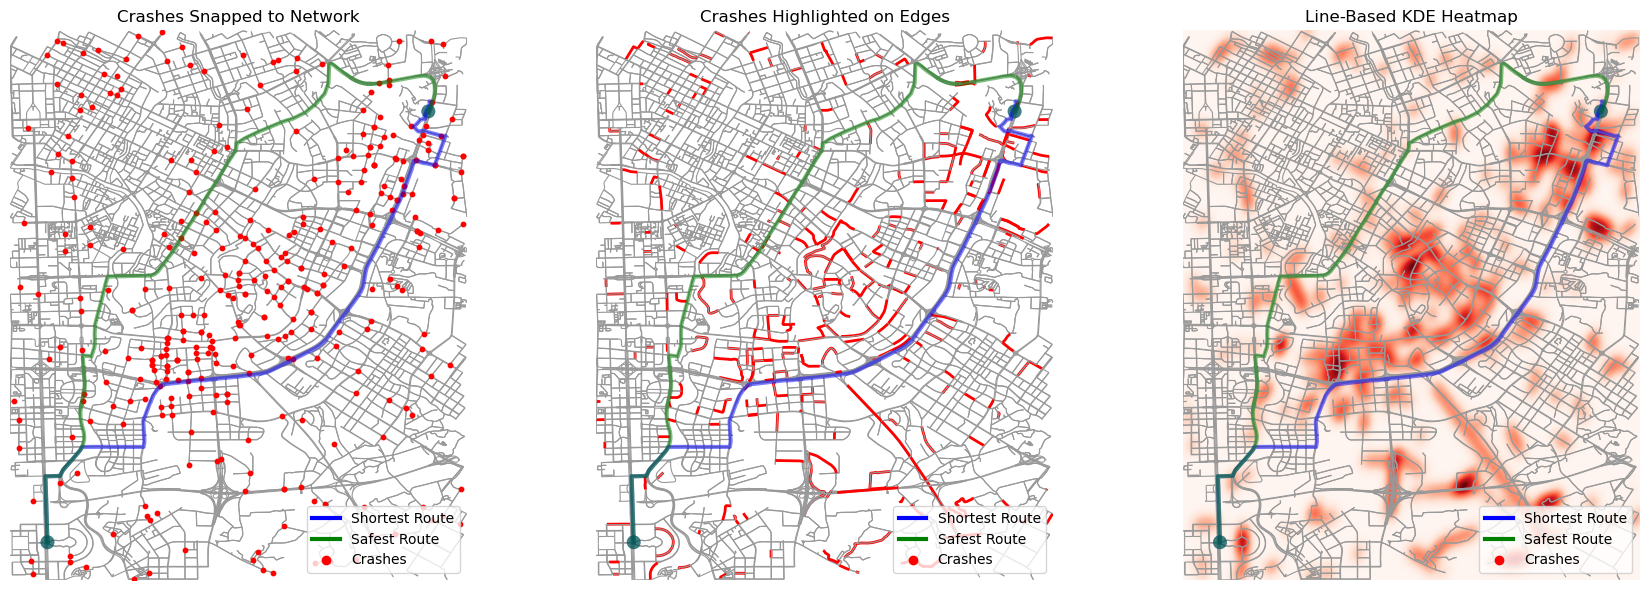

In [8]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from collections import defaultdict
from scipy.stats import gaussian_kde
np.random.seed(12)

# Define the area of interest using the bounding box (bbox)
bbox = (30.5493864, 104.057658, 30.6824752, 104.1682525)

# Load the street network within the bounding box
G = ox.graph_from_bbox(
    north=bbox[2], south=bbox[0], east=bbox[3], west=bbox[1], network_type='drive'
)

# Define starting and ending points (ensure they're different)
orig_point = (30.5593864, 104.067658)  # Near the bottom-left of bbox
dest_point = (30.6624752, 104.1582525)  # Near the top-right of bbox

# Find the nearest network nodes to the origin and destination points
orig_node = ox.nearest_nodes(G, orig_point[1], orig_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])

shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Generate 200 random crash points within the bounding box
num_random_crashes = 200
random_crash_lats = np.random.uniform(bbox[0], bbox[2], num_random_crashes)
random_crash_lons = np.random.uniform(bbox[1], bbox[3], num_random_crashes)
random_crash_points = list(zip(random_crash_lats, random_crash_lons))

# Generate 3 clusters of 50 crash points each
cluster_centers = [
    (30.6, 104.1),
    (30.62, 104.12),
    (30.65, 104.15)
]
num_clusters = 4
points_per_cluster = 50
std_dev = 0.008  # Standard deviation for clusters (~200 meters)
cluster_crash_points = []

for center_lat, center_lon in cluster_centers:
    cluster_lats = np.random.normal(center_lat, std_dev, points_per_cluster)
    cluster_lons = np.random.normal(center_lon, std_dev, points_per_cluster)
    cluster_points = list(zip(cluster_lats, cluster_lons))
    cluster_crash_points.extend(cluster_points)

# Combine random crashes and cluster crashes
crash_points = random_crash_points + cluster_crash_points

# Total number of crashes
total_crashes = num_random_crashes + num_clusters * points_per_cluster

# Snap crash points to the nearest network nodes
crash_nodes = [ox.nearest_nodes(G, lon, lat) for lat, lon in crash_points]

# Get coordinates of snapped crash nodes
crash_x = [G.nodes[node]['x'] for node in crash_nodes]
crash_y = [G.nodes[node]['y'] for node in crash_nodes]

# Find the nearest edge for each crash point and tally crashes to the nearest edge
edge_crash_count = defaultdict(int)
for lat, lon in crash_points:
    nearest_edge = ox.nearest_edges(G, lon, lat)
    edge_crash_count[nearest_edge] += 10

# Add cumulative severity to the edges in the graph
for u, v, key in G.edges(keys=True):
    G[u][v][key]['cumulative_severity'] = edge_crash_count.get((u, v, key), 0)

# Prepare edge colors and widths for plotting
edge_colors = []
edge_widths = []
for u, v, key in G.edges(keys=True):
    severity = G[u][v][key]['cumulative_severity']
    if severity > 0:
        edge_colors.append('red')
        edge_widths.append(2)
    else:
        edge_colors.append('#999999')
        edge_widths.append(0.8)

# Create points along edges with crash severity for the heatmap
line_points = []
for u, v, key, data in G.edges(keys=True, data=True):
    if data['cumulative_severity'] > 0:
        x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
        x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
        num_points = max(int(data['length'] / 10), 2)
        x_vals = np.linspace(x_start, x_end, num_points)
        y_vals = np.linspace(y_start, y_end, num_points)
        line_points.extend([(x, y) for x, y in zip(x_vals, y_vals)])

# Apply Kernel Density Estimation (KDE) to line points
if line_points:
    line_points = np.array(line_points).T
    kde = gaussian_kde(line_points, bw_method=0.05)
    x_coords = [G.nodes[node]['x'] for node in G.nodes()]
    y_coords = [G.nodes[node]['y'] for node in G.nodes()]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    x_grid = np.linspace(x_min, x_max, 500)
    y_grid = np.linspace(y_min, y_max, 500)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)
else:
    Z = None

# Compute the safest route by penalizing edges with crashes
# Define a penalty factor for crashes
penalty_factor = 1000  # Adjust this factor to increase or decrease the penalty severity

# Add a new attribute 'safety_weight' to each edge
for u, v, key, data in G.edges(keys=True, data=True):
    severity = data['cumulative_severity']
    # Calculate the safety weight
    data['safety_weight'] = data['length'] * (1 + penalty_factor * severity)

# Compute the safest route using the 'safety_weight' attribute
safest_route = nx.shortest_path(G, orig_node, dest_node, weight='safety_weight')

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First subplot: Street Network with Route and Crashes
# Plot the street network
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#999999',
    edge_linewidth=0.8,
    bgcolor='white',
    show=False,
    close=False,
    ax=axs[0]
)
# Overlay the shortest route
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='blue',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[0],
    show=False,
    close=False
)
# Overlay the safest route
ox.plot_graph_route(
    G,
    safest_route,
    route_color='green',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[0],
    show=False,
    close=False
)
# Overlay crash points snapped to the network
axs[0].scatter(crash_x, crash_y, c='red', s=10, alpha=1, label='Crashes')
axs[0].set_title("Crashes Snapped to Network", fontsize=12)
axs[0].legend(loc='upper right')

# Second subplot: Street Network with Crashes Highlighted on Edges
ox.plot_graph(
    G,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=edge_widths,
    bgcolor='white',
    show=False,
    close=False,
    ax=axs[1]
)
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='blue',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[1],
    show=False,
    close=False
)
# Plot the safest route on top
ox.plot_graph_route(
    G,
    safest_route,
    route_color='green',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[1],
    show=False,
    close=False
)
axs[1].set_title("Crashes Highlighted on Edges", fontsize=12)

# Third subplot: Street Network with Line-Based KDE Heatmap
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#999999',
    edge_linewidth=0.8,
    bgcolor='white',
    show=False,
    close=False,
    ax=axs[2]
)

if Z is not None:
    axs[2].imshow(
        np.flipud(Z),
        extent=[x_min, x_max, y_min, y_max],
        cmap='Reds',
        alpha=1
    )
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='blue',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[2],
    show=False,
    close=False
)
# Plot the safest route on top
ox.plot_graph_route(
    G,
    safest_route,
    route_color='green',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[2],
    show=False,
    close=False
)
axs[2].set_title("Line-Based KDE Heatmap", fontsize=12)

# Set the same x and y limits and aspect ratio for all subplots
for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')

# Add a legend to explain the routes
handles = [
    plt.Line2D([0], [0], color='blue', lw=3, label='Shortest Route'),
    plt.Line2D([0], [0], color='green', lw=3, label='Safest Route'),
    plt.Line2D([0], [0], color='red', marker='o', linestyle='None', label='Crashes')
]

axs[0].legend(handles=handles, loc='lower right')
axs[1].legend(handles=handles, loc='lower right')
axs[2].legend(handles=handles, loc='lower right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [9]:
cluster_centers = [
    (30.6, 104.1),
    (30.62, 104.12),
    (30.6, 104.13),
    (30.65, 104.15)
]

In [10]:
import geopandas as gpd
from shapely.geometry import LineString

# Function to convert the detailed route to a GeoDataFrame and save it to GeoJSON
def save_detailed_route_to_geojson(G, route, filename):
    # Extract the detailed coordinates along the route
    route_coords = []
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if G.has_edge(u, v):
            # Get the geometry of the edge (may be a LineString with multiple points)
            edge_data = G.get_edge_data(u, v, 0)
            geom = edge_data.get('geometry')
            if geom:
                route_coords.extend(list(geom.coords))
            else:
                # If no geometry is defined, use straight-line approximation
                x1, y1 = G.nodes[u]['x'], G.nodes[u]['y']
                x2, y2 = G.nodes[v]['x'], G.nodes[v]['y']
                route_coords.extend([(x1, y1), (x2, y2)])

    # Create a LineString from the detailed route coordinates
    route_line = LineString(route_coords).simplify(tolerance=0)

    # Create a GeoDataFrame with the LineString
    route_gdf = gpd.GeoDataFrame(geometry=[route_line], crs=G.graph.get('crs'))

    # Transform to WGS84 if not already in WGS84
    if route_gdf.crs is not None and route_gdf.crs.to_string() != 'EPSG:4326':
        route_gdf = route_gdf.to_crs(epsg=4326)

    # Save to GeoJSON
    route_gdf.to_file(filename, driver='GeoJSON')
    print(f"GeoJSON file '{filename}' has been saved successfully.")

# Save the detailed shortest (blue) route
save_detailed_route_to_geojson(G, shortest_route, '/Users/nicholas/Desktop/map/public/shortest_route.geojson')

# Save the detailed safest (green) route
save_detailed_route_to_geojson(G, safest_route, '/Users/nicholas/Desktop/map/public/safest_route.geojson')


GeoJSON file '/Users/nicholas/Desktop/map/public/shortest_route.geojson' has been saved successfully.
GeoJSON file '/Users/nicholas/Desktop/map/public/safest_route.geojson' has been saved successfully.


/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/2373561403.py:16: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(
/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/2373561403.py:16: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(


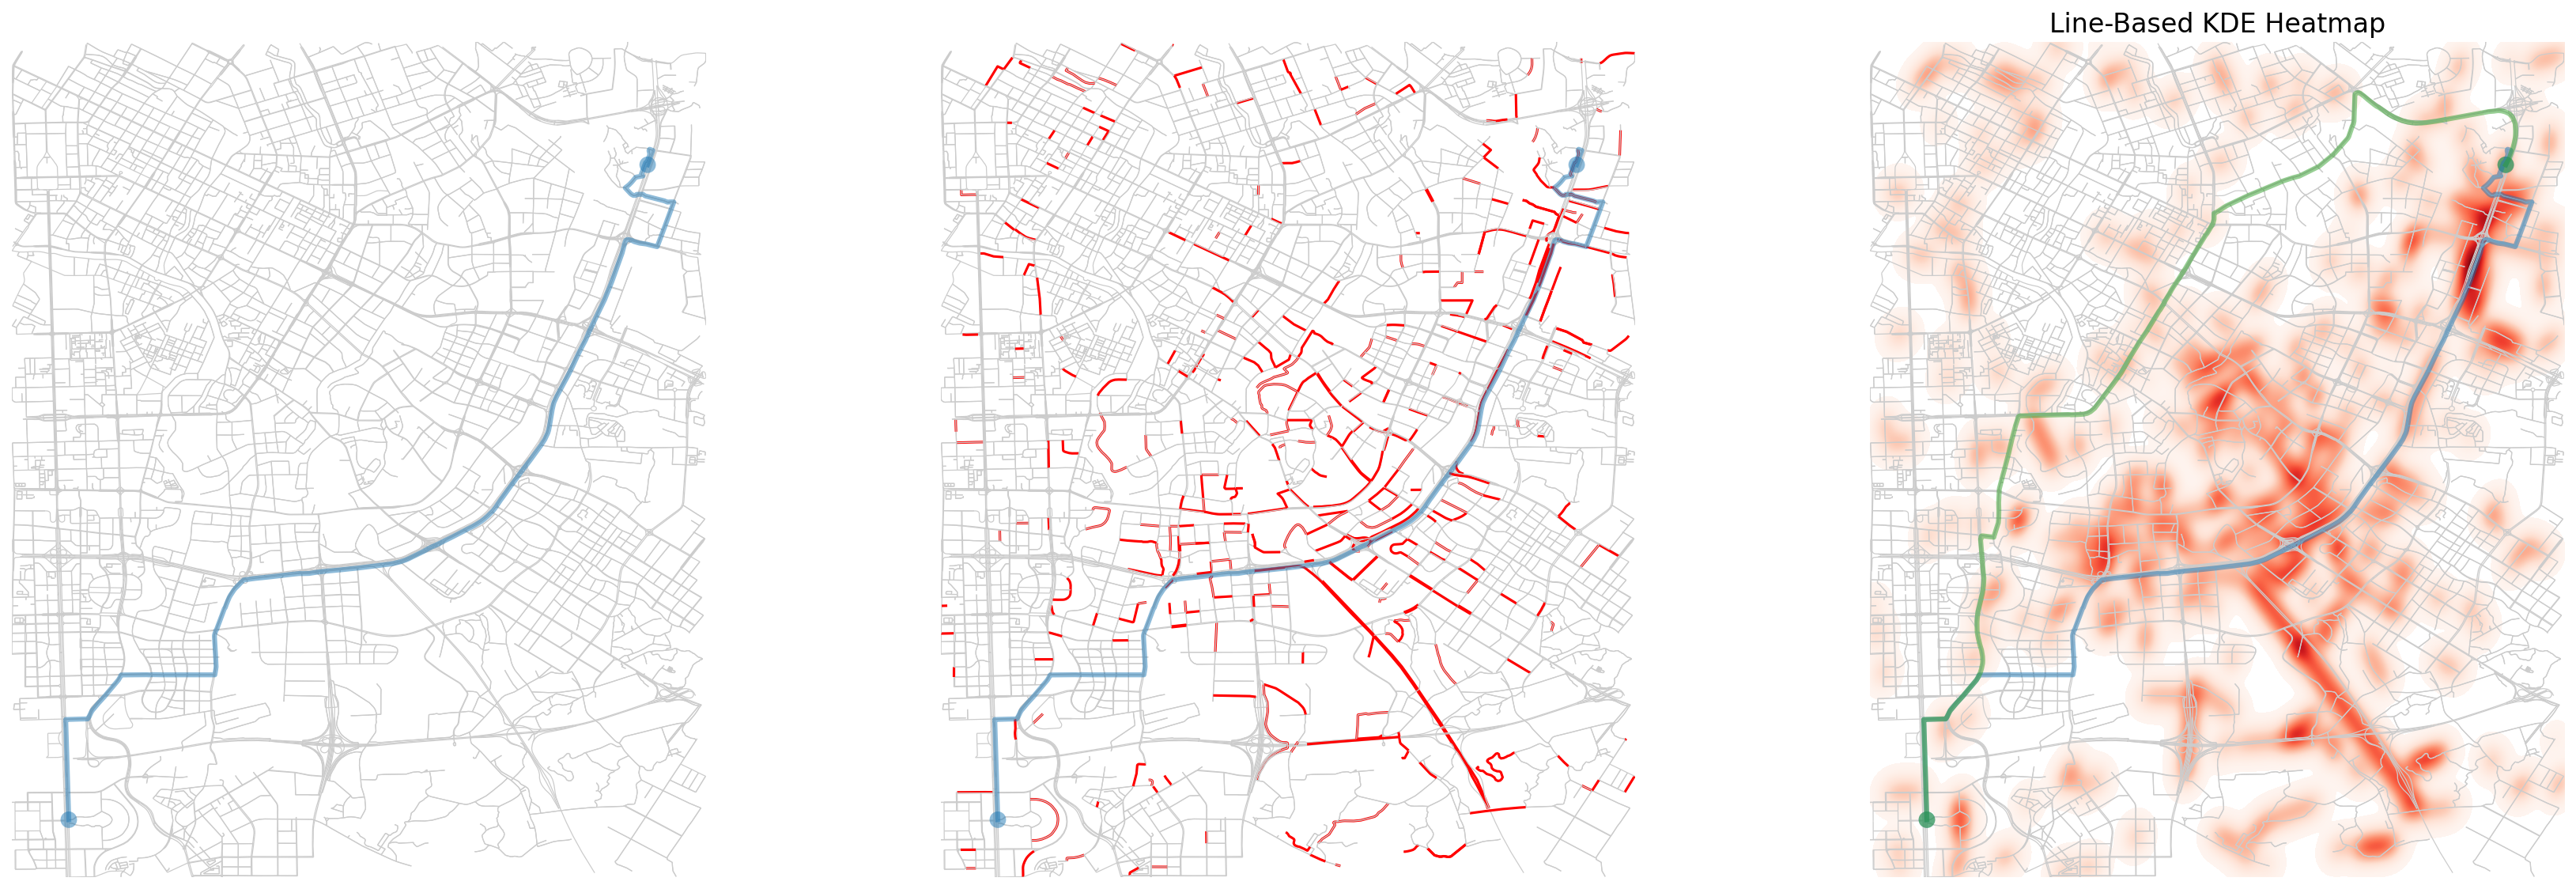

In [25]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from collections import defaultdict
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap

np.random.seed(12)

# Define the area of interest using the bounding box (bbox)
bbox = (30.5493864, 104.057658, 30.6824752, 104.1682525)

# Load the street network within the bounding box
G = ox.graph_from_bbox(
    north=bbox[2], south=bbox[0], east=bbox[3], west=bbox[1], network_type='drive'
)

# Define starting and ending points (ensure they're different)
orig_point = (30.5593864, 104.067658)  # Near the bottom-left of bbox
dest_point = (30.6624752, 104.1582525)  # Near the top-right of bbox

# Find the nearest network nodes to the origin and destination points
orig_node = ox.nearest_nodes(G, orig_point[1], orig_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])

shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Generate 200 random crash points within the bounding box
num_random_crashes = 200
random_crash_lats = np.random.uniform(bbox[0], bbox[2], num_random_crashes)
random_crash_lons = np.random.uniform(bbox[1], bbox[3], num_random_crashes)
random_crash_points = list(zip(random_crash_lats, random_crash_lons))

# Generate 3 clusters of 50 crash points each
cluster_centers = [
    (30.6, 104.1),
    (30.62, 104.12),
    (30.6, 104.13),
    (30.65, 104.15)
]
num_clusters = 3  # Corrected from 4 to 3
points_per_cluster = 50
std_dev = 0.008  # Standard deviation for clusters (~200 meters)
cluster_crash_points = []

for center_lat, center_lon in cluster_centers:
    cluster_lats = np.random.normal(center_lat, std_dev, points_per_cluster)
    cluster_lons = np.random.normal(center_lon, std_dev, points_per_cluster)
    cluster_points = list(zip(cluster_lats, cluster_lons))
    cluster_crash_points.extend(cluster_points)

# Combine random crashes and cluster crashes
crash_points = random_crash_points + cluster_crash_points

# Total number of crashes
total_crashes = num_random_crashes + num_clusters * points_per_cluster

# Snap crash points to the nearest network nodes
crash_nodes = [ox.nearest_nodes(G, lon, lat) for lat, lon in crash_points]

# Get coordinates of snapped crash nodes
crash_x = [G.nodes[node]['x'] for node in crash_nodes]
crash_y = [G.nodes[node]['y'] for node in crash_nodes]

# Find the nearest edge for each crash point and tally crashes to the nearest edge
edge_crash_count = defaultdict(int)
for lat, lon in crash_points:
    nearest_edge = ox.nearest_edges(G, lon, lat)
    edge_crash_count[nearest_edge] += 100

# Add cumulative severity to the edges in the graph
for u, v, key in G.edges(keys=True):
    G[u][v][key]['cumulative_severity'] = edge_crash_count.get((u, v, key), 0)

# Prepare edge colors and widths for plotting
edge_colors = []
edge_widths = []
for u, v, key in G.edges(keys=True):
    severity = G[u][v][key]['cumulative_severity']
    if severity > 0:
        edge_colors.append('red')
        edge_widths.append(1.5)
    else:
        edge_colors.append('#CCCCCC')  # Lighter grey for better contrast
        edge_widths.append(0.6)

# Create points along edges with crash severity for the heatmap
line_points = []
for u, v, key, data in G.edges(keys=True, data=True):
    if data['cumulative_severity'] > 0:
        x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
        x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
        num_points = max(int(data['length'] / 10), 2)
        x_vals = np.linspace(x_start, x_end, num_points)
        y_vals = np.linspace(y_start, y_end, num_points)
        line_points.extend([(x, y) for x, y in zip(x_vals, y_vals)])

# Apply Kernel Density Estimation (KDE) to line points
if line_points:
    line_points = np.array(line_points).T
    kde = gaussian_kde(line_points, bw_method=0.05)
    x_min, x_max = min([G.nodes[node]['x'] for node in G.nodes()]), max([G.nodes[node]['x'] for node in G.nodes()])
    y_min, y_max = min([G.nodes[node]['y'] for node in G.nodes()]), max([G.nodes[node]['y'] for node in G.nodes()])
    x_grid = np.linspace(x_min, x_max, 1000)  # Increased resolution
    y_grid = np.linspace(y_min, y_max, 1000)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)
else:
    Z = None

# Compute the safest route by penalizing edges with crashes
# Define a penalty factor for crashes
penalty_factor = 10  # Adjust this factor to increase or decrease the penalty severity

# Add a new attribute 'safety_weight' to each edge
for u, v, key, data in G.edges(keys=True, data=True):
    severity = data['cumulative_severity']
    # Calculate the safety weight
    data['safety_weight'] = data['length'] * (1 + penalty_factor * severity)

# Compute the safest route using the 'safety_weight' attribute
# safest_route = nx.shortest_path(G, orig_node, dest_node, weight='safety_weight')

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8), dpi=150)  # Increased figure size and resolution

# Define a professional color map for the heatmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the existing 'Reds' colormap
base_reds = plt.get_cmap('Reds')

# Convert the colormap to an array of RGBA values
reds_array = base_reds(np.linspace(0, 1, 256))

# Modify the first color (lowest value) to white
reds_array[0] = np.array([1, 1, 1, 1])  # RGBA for white

# Create a new colormap from the modified array
custom_reds = LinearSegmentedColormap.from_list('custom_reds', reds_array)

# Assign the custom colormap to `heatmap_cmap`
heatmap_cmap = custom_reds


# First subplot: Street Network with Route and Crashes
# Plot the street network
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#CCCCCC',  # Lighter grey for better contrast
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False,
    ax=axs[0]
)
# Overlay the shortest route
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',  # Professional blue
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[0],
    show=False,
    close=False
)
# Overlay the safest route
# ox.plot_graph_route(
#     G,
#     safest_route,
#     route_color='#33a02c',  # Professional green
#     route_linewidth=3,
#     node_size=0,
#     bgcolor=None,
#     ax=axs[0],
#     show=False,
#     close=False
# )
# Overlay crash points snapped to the network
# axs[0].scatter(crash_x, crash_y, c='red', s=10, alpha=0.7, label='Crashes')
# axs[0].set_title("Crashes Snapped to Network", fontsize=16)
# axs[0].legend(loc='upper right', fontsize=12)

# Second subplot: Street Network with Crashes Highlighted on Edges
ox.plot_graph(
    G,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=edge_widths,
    bgcolor='white',
    show=False,
    close=False,
    ax=axs[1]
)
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[1],
    show=False,
    close=False
)
# # Plot the safest route on top
# ox.plot_graph_route(
#     G,
#     safest_route,
#     route_color='#33a02c',
#     route_linewidth=3,
#     node_size=0,
#     bgcolor=None,
#     ax=axs[1],
#     show=False,
#     close=False
# )
# axs[1].set_title("Crashes Highlighted on Edges", fontsize=16)

# Third subplot: Street Network with Line-Based KDE Heatmap
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#CCCCCC',
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False,
    ax=axs[2]
)

if Z is not None:
    # Normalize Z for better color scaling
    Z_normalized = Z / Z.max()
    axs[2].imshow(
        np.flipud(Z_normalized),
        extent=[x_min, x_max, y_min, y_max],
        cmap=heatmap_cmap,
        alpha=1,  # Increased transparency
        aspect='auto'
    )
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[2],
    show=False,
    close=False
)
# Plot the safest route on top
ox.plot_graph_route(
    G,
    safest_route,
    route_color='#33a02c',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=axs[2],
    show=False,
    close=False
)
axs[2].set_title("Line-Based KDE Heatmap", fontsize=16)

# Add a color bar for the heatmap
# if Z is not None:
#     cbar = fig.colorbar(
#         plt.cm.ScalarMappable(cmap=heatmap_cmap),
#         ax=axs[2],
#         orientation='vertical',
#         fraction=0.046,
#         pad=0.04
#     )

# Set the same x and y limits and aspect ratio for all subplots
for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.axis('off')  # Remove axis for a cleaner look

# Add a unified legend for all subplots
handles = [
    plt.Line2D([0], [0], color='#1f78b4', lw=3, label='Shortest Route'),
    plt.Line2D([0], [0], color='#33a02c', lw=3, label='Safest Route'),
    plt.Line2D([0], [0], marker='o', color='w', label='Crashes',
               markerfacecolor='red', markersize=8, alpha=0.7)
]

# Adjust layout and save the plot with high resolution
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make space for the legend
# plt.suptitle("Traffic Crash Analysis and Route Optimization", fontsize=20, y=0.98)
plt.savefig("professional_crash_heatmap.png", dpi=300)
plt.show()


In [26]:
# Function to save individual subplots
def save_subplot_individually(G, route, crash_x, crash_y, edge_colors, edge_widths, Z, x_min, x_max, y_min, y_max, filename, plot_type):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

    if plot_type == 'route_and_crashes':
        # Plot the street network
        ox.plot_graph(
            G,
            node_size=0,
            edge_color='#CCCCCC',
            edge_linewidth=0.6,
            bgcolor='white',
            show=False,
            close=False,
            ax=ax
        )
        # Plot the shortest route
        ox.plot_graph_route(
            G,
            route,
            route_color='#1f78b4',
            route_linewidth=3,
            node_size=0,
            bgcolor=None,
            ax=ax,
            show=False,
            close=False
        )
        # Overlay crash points
        ax.scatter(crash_x, crash_y, c='red', s=10, alpha=0.7)
        ax.set_title("Route with Crashes", fontsize=16)

    elif plot_type == 'crashes_on_edges':
        # Plot the street network with crash severity
        ox.plot_graph(
            G,
            node_size=0,
            edge_color=edge_colors,
            edge_linewidth=edge_widths,
            bgcolor='white',
            show=False,
            close=False,
            ax=ax
        )
        # Plot the shortest route
        ox.plot_graph_route(
            G,
            route,
            route_color='#1f78b4',
            route_linewidth=3,
            node_size=0,
            bgcolor=None,
            ax=ax,
            show=False,
            close=False
        )
        ax.set_title("Crashes Highlighted on Edges", fontsize=16)

    elif plot_type == 'kde_heatmap':
        # Plot the street network
        ox.plot_graph(
            G,
            node_size=0,
            edge_color='#CCCCCC',
            edge_linewidth=0.6,
            bgcolor='white',
            show=False,
            close=False,
            ax=ax
        )
        # Plot KDE heatmap
        if Z is not None:
            Z_normalized = Z / Z.max()
            ax.imshow(
                np.flipud(Z_normalized),
                extent=[x_min, x_max, y_min, y_max],
                cmap=heatmap_cmap,
                alpha=1,
                aspect='auto'
            )
        # Plot the shortest route
        ox.plot_graph_route(
            G,
            route,
            route_color='#1f78b4',
            route_linewidth=3,
            node_size=0,
            bgcolor=None,
            ax=ax,
            show=False,
            close=False
        )
        ax.set_title("KDE Heatmap", fontsize=16)

    # Set limits and aspect ratio
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close(fig)

# Save each subplot separately
save_subplot_individually(
    G, shortest_route, crash_x, crash_y, edge_colors, edge_widths, Z, x_min, x_max, y_min, y_max,
    "subplot1_route_and_crashes.png", plot_type='route_and_crashes'
)
save_subplot_individually(
    G, shortest_route, crash_x, crash_y, edge_colors, edge_widths, Z, x_min, x_max, y_min, y_max,
    "subplot2_crashes_on_edges.png", plot_type='crashes_on_edges'
)
save_subplot_individually(
    G, shortest_route, crash_x, crash_y, edge_colors, edge_widths, Z, x_min, x_max, y_min, y_max,
    "subplot3_kde_heatmap.png", plot_type='kde_heatmap'
)

print("Saved subplots as separate images.")


Saved subplots as separate images.


In [28]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from collections import defaultdict
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap

np.random.seed(12)

# Define the area of interest using the bounding box (bbox)
bbox = (30.5493864, 104.057658, 30.6824752, 104.1682525)

# Load the street network within the bounding box
G = ox.graph_from_bbox(
    north=bbox[2], south=bbox[0], east=bbox[3], west=bbox[1], network_type='drive'
)

# Define starting and ending points (ensure they're different)
orig_point = (30.5593864, 104.067658)  # Near the bottom-left of bbox
dest_point = (30.6624752, 104.1582525)  # Near the top-right of bbox

# Find the nearest network nodes to the origin and destination points
orig_node = ox.nearest_nodes(G, orig_point[1], orig_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])

shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Generate 200 random crash points within the bounding box
num_random_crashes = 200
random_crash_lats = np.random.uniform(bbox[0], bbox[2], num_random_crashes)
random_crash_lons = np.random.uniform(bbox[1], bbox[3], num_random_crashes)
random_crash_points = list(zip(random_crash_lats, random_crash_lons))

# Generate 3 clusters of 50 crash points each
cluster_centers = [
    (30.6, 104.1),
    (30.62, 104.12),
    (30.6, 104.13),
    (30.65, 104.15)
]
num_clusters = 3  # Corrected from 4 to 3
points_per_cluster = 50
std_dev = 0.008  # Standard deviation for clusters (~200 meters)
cluster_crash_points = []

for center_lat, center_lon in cluster_centers:
    cluster_lats = np.random.normal(center_lat, std_dev, points_per_cluster)
    cluster_lons = np.random.normal(center_lon, std_dev, points_per_cluster)
    cluster_points = list(zip(cluster_lats, cluster_lons))
    cluster_crash_points.extend(cluster_points)

# Combine random crashes and cluster crashes
crash_points = random_crash_points + cluster_crash_points

# Total number of crashes
total_crashes = num_random_crashes + num_clusters * points_per_cluster

# Snap crash points to the nearest network nodes
crash_nodes = [ox.nearest_nodes(G, lon, lat) for lat, lon in crash_points]

# Get coordinates of snapped crash nodes
crash_x = [G.nodes[node]['x'] for node in crash_nodes]
crash_y = [G.nodes[node]['y'] for node in crash_nodes]

# Find the nearest edge for each crash point and tally crashes to the nearest edge
edge_crash_count = defaultdict(int)
for lat, lon in crash_points:
    nearest_edge = ox.nearest_edges(G, lon, lat)
    edge_crash_count[nearest_edge] += 100

# Add cumulative severity to the edges in the graph
for u, v, key in G.edges(keys=True):
    G[u][v][key]['cumulative_severity'] = edge_crash_count.get((u, v, key), 0)

# Prepare edge colors and widths for plotting
edge_colors = []
edge_widths = []
for u, v, key in G.edges(keys=True):
    severity = G[u][v][key]['cumulative_severity']
    if severity > 0:
        edge_colors.append('red')
        edge_widths.append(1.5)
    else:
        edge_colors.append('#CCCCCC')  # Lighter grey for better contrast
        edge_widths.append(0.6)

# Create points along edges with crash severity for the heatmap
line_points = []
for u, v, key, data in G.edges(keys=True, data=True):
    if data['cumulative_severity'] > 0:
        x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
        x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
        num_points = max(int(data['length'] / 10), 2)
        x_vals = np.linspace(x_start, x_end, num_points)
        y_vals = np.linspace(y_start, y_end, num_points)
        line_points.extend([(x, y) for x, y in zip(x_vals, y_vals)])

# Apply Kernel Density Estimation (KDE) to line points
if line_points:
    line_points = np.array(line_points).T
    kde = gaussian_kde(line_points, bw_method=0.05)
    x_min, x_max = min([G.nodes[node]['x'] for node in G.nodes()]), max([G.nodes[node]['x'] for node in G.nodes()])
    y_min, y_max = min([G.nodes[node]['y'] for node in G.nodes()]), max([G.nodes[node]['y'] for node in G.nodes()])
    x_grid = np.linspace(x_min, x_max, 1000)  # Increased resolution
    y_grid = np.linspace(y_min, y_max, 1000)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)
else:
    Z = None

# Define a professional color map for the heatmap
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# Retrieve the existing 'Reds' colormap
base_reds = plt.get_cmap('Reds')

# Convert the colormap to an array of RGBA values
reds_array = base_reds(np.linspace(0, 1, 256))

# Modify the first color (lowest value) to white
reds_array[0] = np.array([1, 1, 1, 1])  # RGBA for white

# Create a new colormap from the modified array
custom_reds = LinearSegmentedColormap.from_list('custom_reds', reds_array)

# Assign the custom colormap to heatmap_cmap
heatmap_cmap = custom_reds

# Set consistent x and y limits for all subplots
x_min, x_max = min([G.nodes[node]['x'] for node in G.nodes()]), max([G.nodes[node]['x'] for node in G.nodes()])
y_min, y_max = min([G.nodes[node]['y'] for node in G.nodes()]), max([G.nodes[node]['y'] for node in G.nodes()])

# First Subplot: Street Network with Route
fig1, ax1 = plt.subplots(figsize=(8, 8), dpi=150)

# Plot the street network
ox.plot_graph(
    G,
    ax=ax1,
    node_size=0,
    edge_color='#CCCCCC',
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False
)

# Overlay the shortest route
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax1,
    show=False,
    close=False
)

# Set x and y limits, aspect ratio, axis off
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_aspect('equal')
ax1.axis('off')

# Save the figure
fig1.savefig("subplot1.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig1)  # Close the figure to free memory

# Second Subplot: Street Network with Crashes Highlighted on Edges
fig2, ax2 = plt.subplots(figsize=(8, 8), dpi=150)

# Plot the street network with crashes highlighted on edges
ox.plot_graph(
    G,
    ax=ax2,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=edge_widths,
    bgcolor='white',
    show=False,
    close=False
)

# Overlay the shortest route
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax2,
    show=False,
    close=False
)

# Set x and y limits, aspect ratio, axis off
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_aspect('equal')
ax2.axis('off')

# Save the figure
fig2.savefig("subplot2.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig2)  # Close the figure to free memory

# Third Subplot: Street Network with Line-Based KDE Heatmap
fig3, ax3 = plt.subplots(figsize=(8, 8), dpi=150)

# Plot the street network
ox.plot_graph(
    G,
    ax=ax3,
    node_size=0,
    edge_color='#CCCCCC',
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False
)

if Z is not None:
    # Normalize Z for better color scaling
    Z_normalized = Z / Z.max()
    ax3.imshow(
        np.flipud(Z_normalized),
        extent=[x_min, x_max, y_min, y_max],
        cmap=heatmap_cmap,
        alpha=1,
        aspect='auto'
    )

# Overlay the shortest route
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax3,
    show=False,
    close=False
)

# Overlay the shortest route
ox.plot_graph_route(
    G,
    safest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax3,
    show=False,
    close=False
)

# Set x and y limits, aspect ratio, axis off
ax3.set_xlim(x_min, x_max)
ax3.set_ylim(y_min, y_max)
ax3.set_aspect('equal')
ax3.axis('off')

# Save the figure
fig3.savefig("subplot3.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig3)  # Close the figure to free memory


/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/3997737535.py:16: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(
/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/3997737535.py:16: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(


In [29]:
ox.plot_graph_route(
    G,
    safest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax3,
    show=False,
    close=False
)

(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

In [30]:
safest_route

[5486634284,
 8916684379,
 3043268877,
 2471834747,
 3043348584,
 8916684371,
 11693698888,
 2331367415,
 11693698892,
 4547050337,
 3043190778,
 3043190773,
 4547049732,
 4547050375,
 4547050441,
 4752613159,
 7618650252,
 7618650253,
 11807439692,
 5505683116,
 5505684525,
 5505684527,
 672395815,
 8047787314,
 8047787315,
 7832207128,
 7832207122,
 4547074301,
 7832207129,
 4547074335,
 4699360138,
 4547074376,
 4547074324,
 8349517161,
 2731947764,
 2729157103,
 1159171719,
 1159171641,
 2733352548,
 1159172500,
 4701577745,
 2708961596,
 4548142607,
 4701577759,
 1819305474,
 2333184029,
 479902231,
 479902236,
 4548318082,
 479902256,
 2080646464,
 2081197474,
 4548209372,
 2315717685,
 2333193192,
 2315717699,
 8279158601,
 9071200812,
 2315717687,
 2315717850,
 5141468785,
 1159155385,
 2456925088,
 3445777695,
 5489098134,
 2456925106,
 8279158556,
 8279158557,
 1459057463,
 1459065027,
 1460291850,
 5529818178,
 1460300834,
 1460304817,
 1460306173,
 1460309118,
 1460310679,


/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/3436976921.py:17: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(
/var/folders/g5/m5vc66b94_1_h1fx73nwh9jw0000gn/T/ipykernel_80819/3436976921.py:17: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(


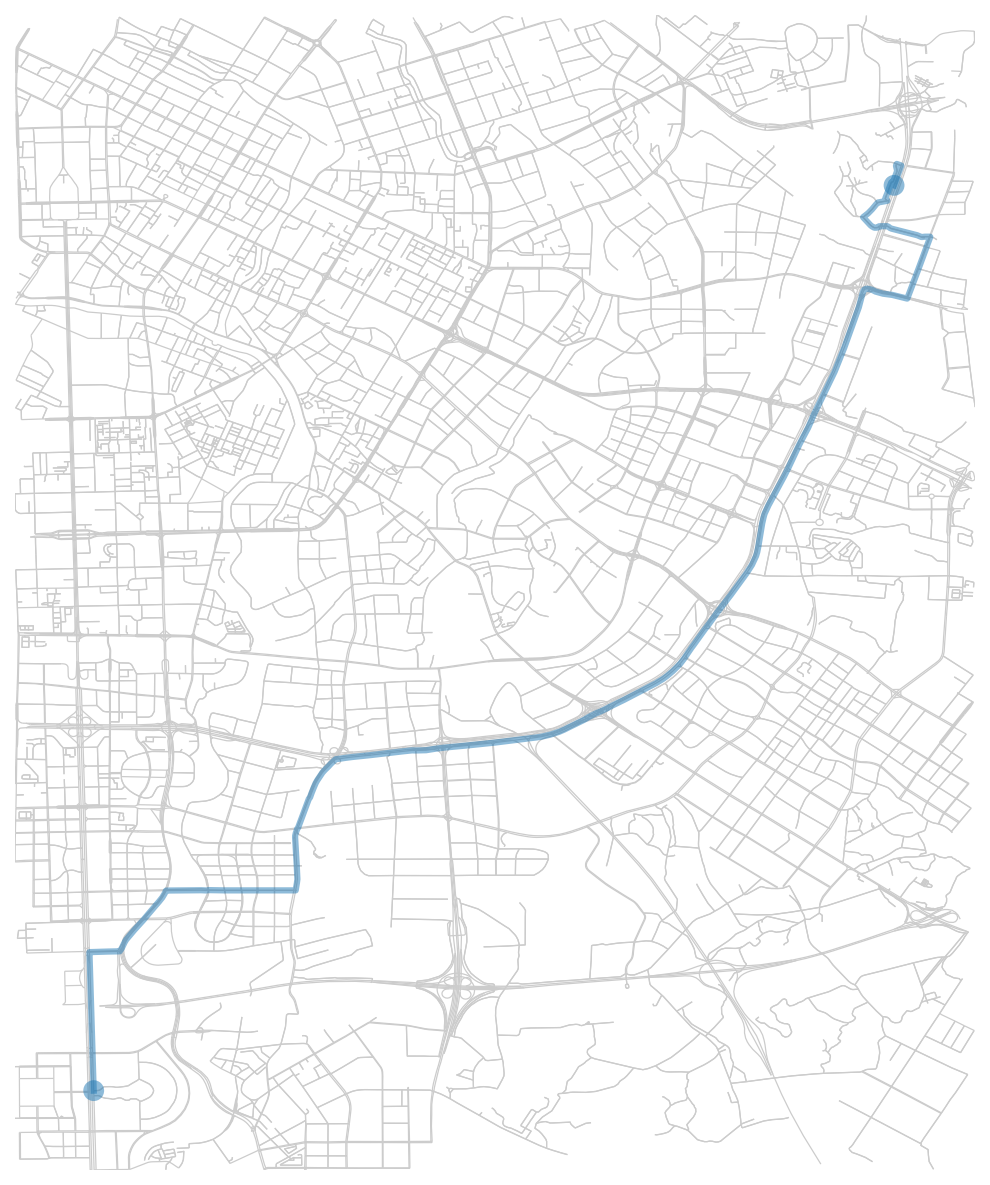

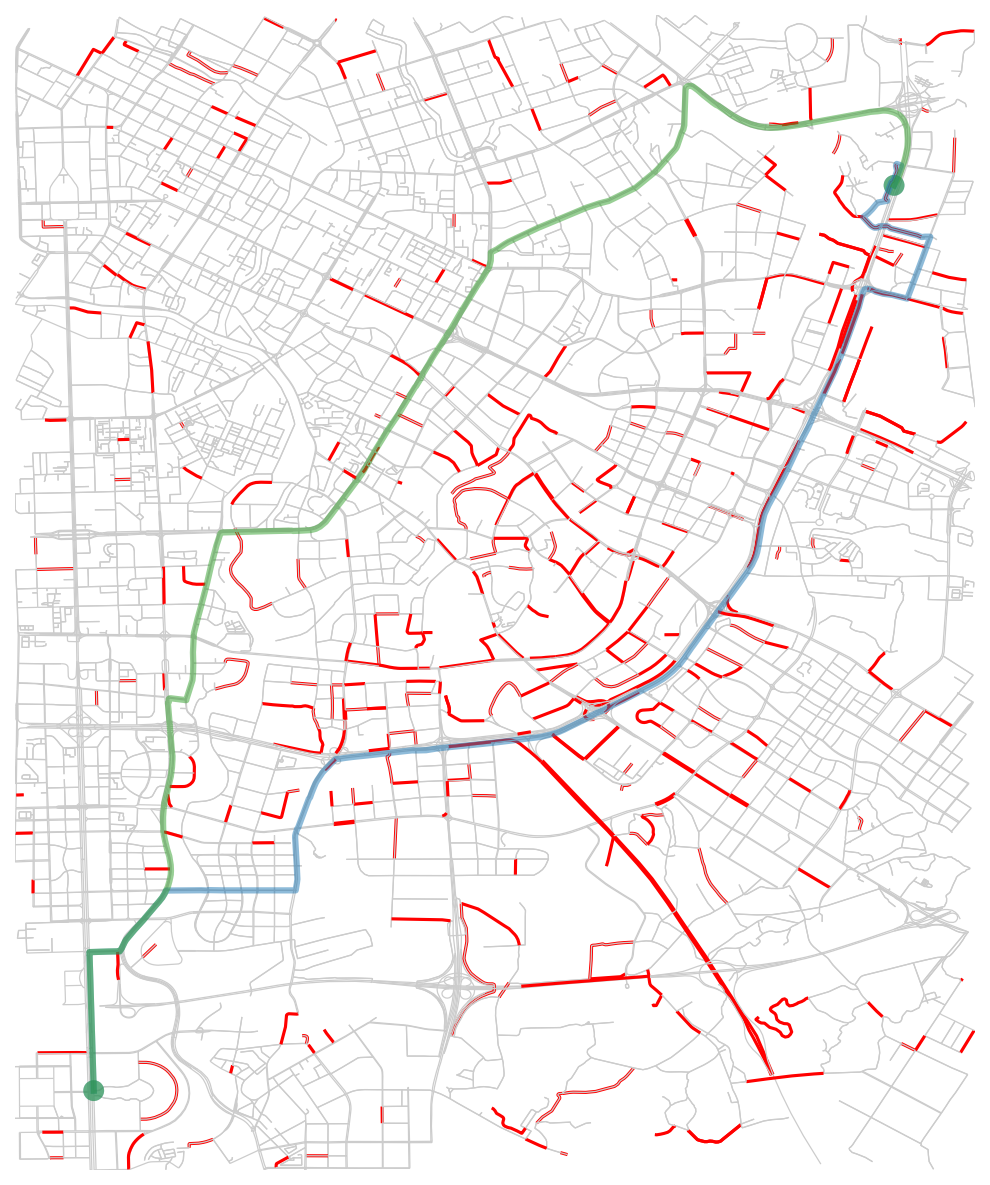

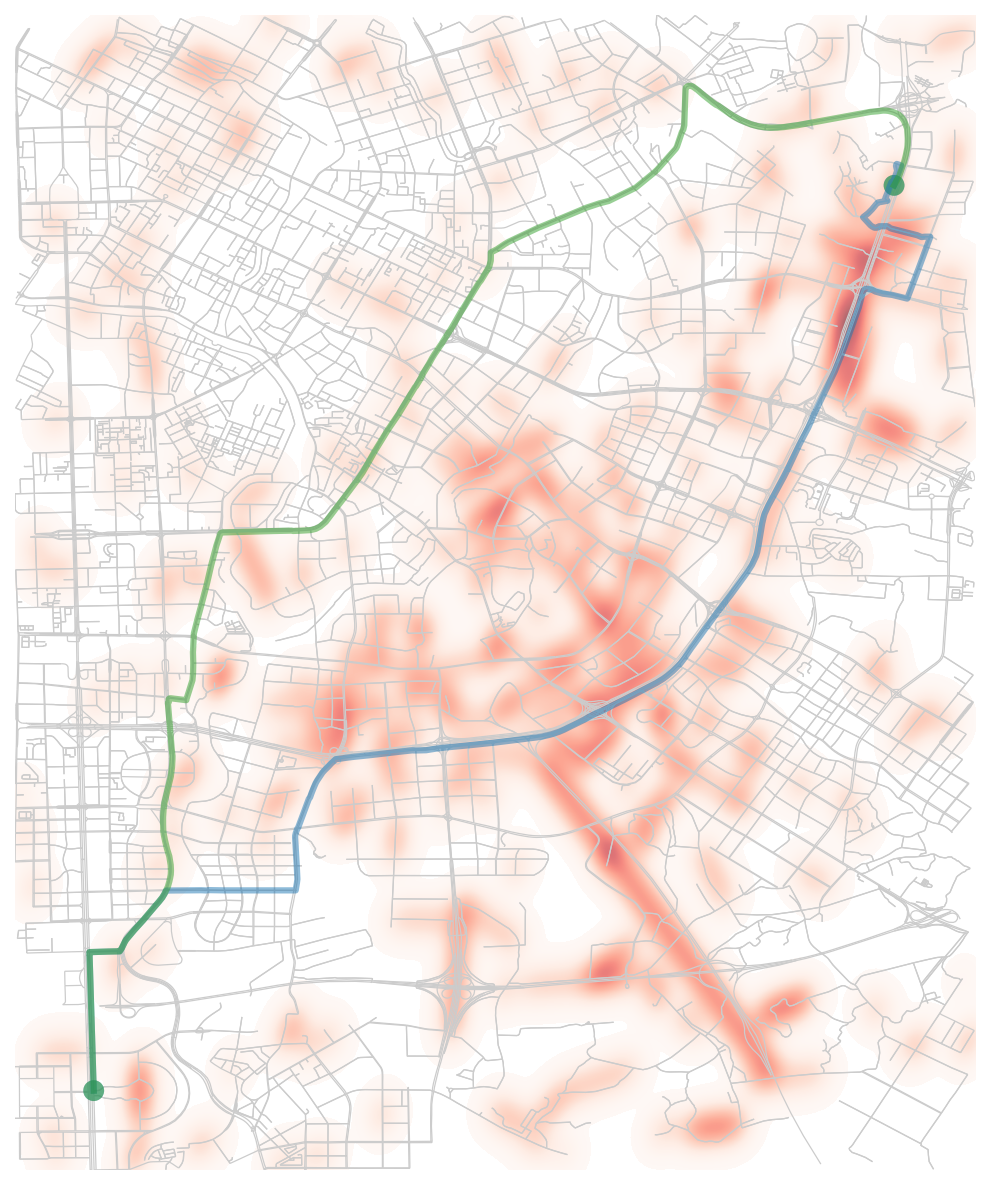

In [35]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from collections import defaultdict
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(12)

# Define the area of interest using the bounding box (bbox)
bbox = (30.5493864, 104.057658, 30.6824752, 104.1682525)

# Load the street network within the bounding box
G = ox.graph_from_bbox(
    north=bbox[2], south=bbox[0], east=bbox[3], west=bbox[1], network_type='drive'
)

# Define starting and ending points (ensure they're different)
orig_point = (30.5593864, 104.067658)  # Near the bottom-left of bbox
dest_point = (30.6624752, 104.1582525)  # Near the top-right of bbox

# Find the nearest network nodes to the origin and destination points
orig_node = ox.nearest_nodes(G, orig_point[1], orig_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])

shortest_route = nx.shortest_path(G, orig_node, dest_node, weight='length')

# Generate 200 random crash points within the bounding box
num_random_crashes = 200
random_crash_lats = np.random.uniform(bbox[0], bbox[2], num_random_crashes)
random_crash_lons = np.random.uniform(bbox[1], bbox[3], num_random_crashes)
random_crash_points = list(zip(random_crash_lats, random_crash_lons))

# Generate 3 clusters of 50 crash points each
cluster_centers = [
    (30.6, 104.1),
    (30.62, 104.12),
    (30.6, 104.13),
    (30.65, 104.15)
]
num_clusters = 3  # Corrected from 4 to 3
points_per_cluster = 50
std_dev = 0.008  # Standard deviation for clusters (~200 meters)
cluster_crash_points = []

for center_lat, center_lon in cluster_centers:
    cluster_lats = np.random.normal(center_lat, std_dev, points_per_cluster)
    cluster_lons = np.random.normal(center_lon, std_dev, points_per_cluster)
    cluster_points = list(zip(cluster_lats, cluster_lons))
    cluster_crash_points.extend(cluster_points)

# Combine random crashes and cluster crashes
crash_points = random_crash_points + cluster_crash_points

# Total number of crashes
total_crashes = num_random_crashes + num_clusters * points_per_cluster

# Snap crash points to the nearest network nodes
crash_nodes = [ox.nearest_nodes(G, lon, lat) for lat, lon in crash_points]

# Get coordinates of snapped crash nodes
crash_x = [G.nodes[node]['x'] for node in crash_nodes]
crash_y = [G.nodes[node]['y'] for node in crash_nodes]

# Find the nearest edge for each crash point and tally crashes to the nearest edge
edge_crash_count = defaultdict(int)
for lat, lon in crash_points:
    nearest_edge = ox.nearest_edges(G, lon, lat)
    edge_crash_count[nearest_edge] += 100

# Add cumulative severity to the edges in the graph
for u, v, key in G.edges(keys=True):
    G[u][v][key]['cumulative_severity'] = edge_crash_count.get((u, v, key), 0)

# Prepare edge colors and widths for plotting
edge_colors = []
edge_widths = []
for u, v, key in G.edges(keys=True):
    severity = G[u][v][key]['cumulative_severity']
    if severity > 0:
        edge_colors.append('red')
        edge_widths.append(1.5)
    else:
        edge_colors.append('#CCCCCC')  # Lighter grey for better contrast
        edge_widths.append(0.6)

# Create points along edges with crash severity for the heatmap
line_points = []
for u, v, key, data in G.edges(keys=True, data=True):
    if data['cumulative_severity'] > 0:
        x_start, y_start = G.nodes[u]['x'], G.nodes[u]['y']
        x_end, y_end = G.nodes[v]['x'], G.nodes[v]['y']
        num_points = max(int(data['length'] / 10), 2)
        x_vals = np.linspace(x_start, x_end, num_points)
        y_vals = np.linspace(y_start, y_end, num_points)
        line_points.extend([(x, y) for x, y in zip(x_vals, y_vals)])

# Apply Kernel Density Estimation (KDE) to line points
if line_points:
    line_points = np.array(line_points).T
    kde = gaussian_kde(line_points, bw_method=0.05)
    x_min, x_max = min([G.nodes[node]['x'] for node in G.nodes()]), max([G.nodes[node]['x'] for node in G.nodes()])
    y_min, y_max = min([G.nodes[node]['y'] for node in G.nodes()]), max([G.nodes[node]['y'] for node in G.nodes()])
    x_grid = np.linspace(x_min, x_max, 1000)  # Increased resolution
    y_grid = np.linspace(y_min, y_max, 1000)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    Z = kde(np.vstack([X_grid.ravel(), Y_grid.ravel()])).reshape(X_grid.shape)
else:
    Z = None

# Compute the safest route by penalizing edges with crashes
# Define a penalty factor for crashes
penalty_factor = 10  # Adjust this factor to increase or decrease the penalty severity

# Add a new attribute 'safety_weight' to each edge
for u, v, key, data in G.edges(keys=True, data=True):
    severity = data['cumulative_severity']
    # Calculate the safety weight
    data['safety_weight'] = data['length'] * (1 + penalty_factor * severity)

# Assume 'safest_route' is defined elsewhere as per your instruction
# safest_route = nx.shortest_path(G, orig_node, dest_node, weight='safety_weight')

# Retrieve the existing 'Reds' colormap and create a custom colormap
base_reds = plt.get_cmap('Reds')
reds_array = base_reds(np.linspace(0, 1, 256))
reds_array[0] = np.array([1, 1, 1, 1])  # RGBA for white
custom_reds = LinearSegmentedColormap.from_list('custom_reds', reds_array)
heatmap_cmap = custom_reds

# Set figure size and DPI for consistency
figsize = (8, 8)
dpi = 150

# Define x and y limits once for all figures
x_min, x_max = min([G.nodes[node]['x'] for node in G.nodes()]), max([G.nodes[node]['x'] for node in G.nodes()])
y_min, y_max = min([G.nodes[node]['y'] for node in G.nodes()]), max([G.nodes[node]['y'] for node in G.nodes()])

### First Figure: Street Network with Route and Crashes ###
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot the street network
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#CCCCCC',  # Lighter grey for better contrast
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False,
    ax=ax
)
# Overlay the shortest route
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',  # Professional blue
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False
)
# Overlay the safest route
# ox.plot_graph_route(
#     G,
#     safest_route,
#     route_color='#33a02c',  # Professional green
#     route_linewidth=3,
#     node_size=0,
#     bgcolor=None,
#     ax=ax,
#     show=False,
#     close=False
# )

# Set limits and aspect ratio
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axis('off')

# Save the figure
plt.tight_layout()
plt.savefig("figure1.png", dpi=300)
plt.show()

### Second Figure: Street Network with Crashes Highlighted on Edges ###
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot the street network with edge colors and widths
ox.plot_graph(
    G,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=edge_widths,
    bgcolor='white',
    show=False,
    close=False,
    ax=ax
)
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False
)
# Plot the safest route on top
ox.plot_graph_route(
    G,
    safest_route,
    route_color='#33a02c',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False
)

# Set limits and aspect ratio
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axis('off')

# Save the figure
plt.tight_layout()
plt.savefig("figure2.png", dpi=300)
plt.show()

### Third Figure: Street Network with Line-Based KDE Heatmap ###
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot the street network
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#CCCCCC',
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False,
    ax=ax
)

if Z is not None:
    # Normalize Z for better color scaling
    Z_normalized = Z / Z.max()
    ax.imshow(
        np.flipud(Z_normalized),
        extent=[x_min, x_max, y_min, y_max],
        cmap=heatmap_cmap,
        alpha=0.6,  # Increased transparency
        aspect='auto'
    )
    
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#1f78b4',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False,
    alpha=0.5
)

# Plot the safest route on top
ox.plot_graph_route(
    G,
    safest_route,
    route_color='#33a02c',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False
)

# Set limits and aspect ratio
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axis('off')

# Save the figure
plt.tight_layout()
plt.savefig("figure3.png", dpi=300)
plt.show()


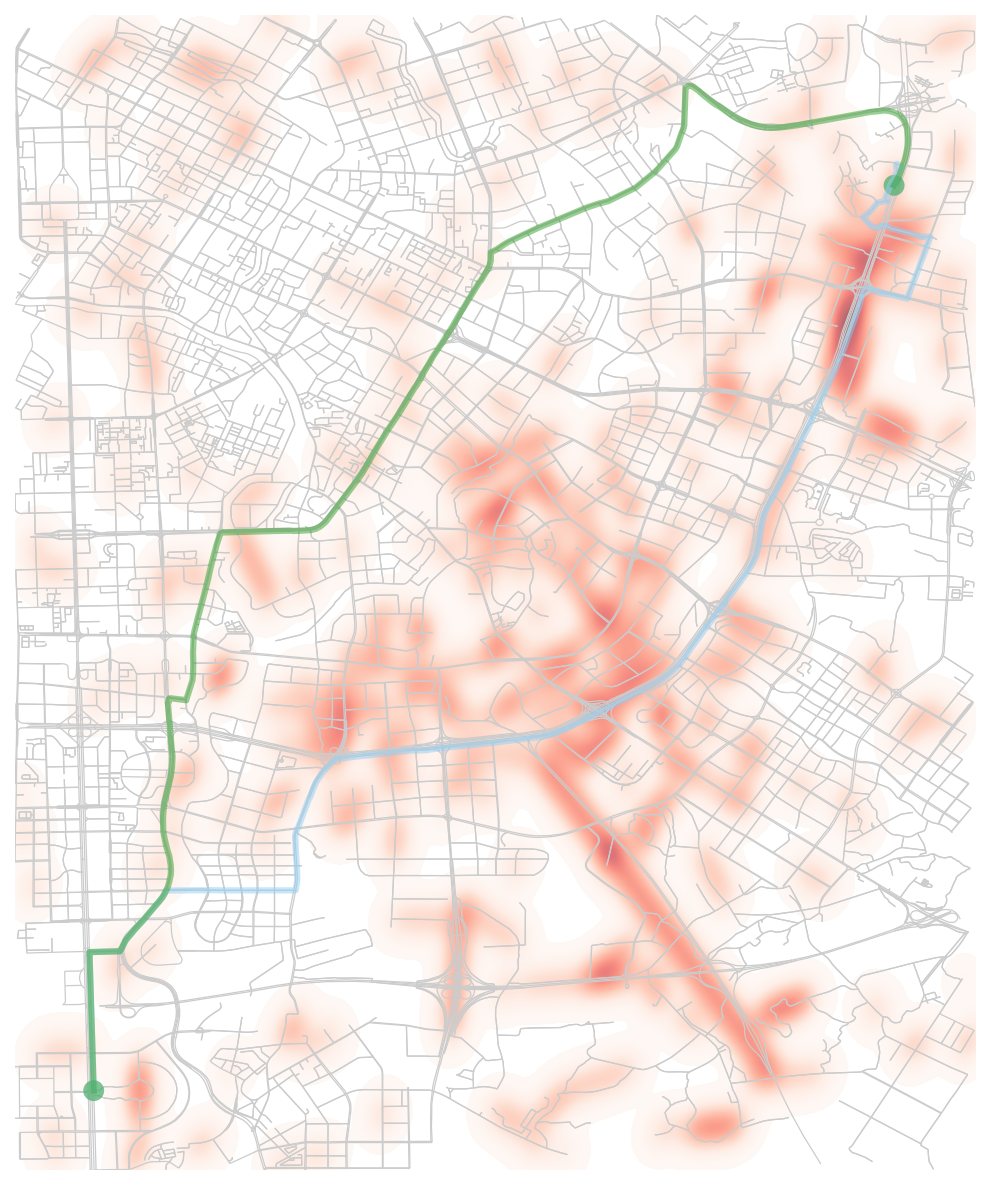

In [42]:

### Third Figure: Street Network with Line-Based KDE Heatmap ###
fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Plot the street network
ox.plot_graph(
    G,
    node_size=0,
    edge_color='#CCCCCC',
    edge_linewidth=0.6,
    bgcolor='white',
    show=False,
    close=False,
    ax=ax
)

if Z is not None:
    # Normalize Z for better color scaling
    Z_normalized = Z / Z.max()
    ax.imshow(
        np.flipud(Z_normalized),
        extent=[x_min, x_max, y_min, y_max],
        cmap=heatmap_cmap,
        alpha=0.6,  # Increased transparency
        aspect='auto'
    )
    
# Plot the shortest route on top
ox.plot_graph_route(
    G,
    shortest_route,
    route_color='#90cff5',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False,
    alpha=0.0
)

# Plot the safest route on top
ox.plot_graph_route(
    G,
    safest_route,
    route_color='#33a02c',
    route_linewidth=3,
    node_size=0,
    bgcolor=None,
    ax=ax,
    show=False,
    close=False
)

# Set limits and aspect ratio
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect('equal')
ax.axis('off')

# Save the figure
plt.tight_layout()
plt.savefig("figure3.png", dpi=300)
plt.show()